# Generating a QDYN runfolder for a system of two transmons

We will generate a runfolder for a Hamiltonian corresponding to Eq. (1) in [arxiv:1606.08825](https://arxiv.org/abs/1606.08825v3), using the `qdynpylib` library:

In [1]:
import QDYN

We also require the the latest development branch of [QNET](https://github.com/mabuchilab/QNET) and a recent version of [QuTiP](http://qutip.org) to be installed.

The parameters for the model are as follows:

In [2]:
w1     = 6000.0 # MHz
w2     = 5900.0 # MHz
wc     = 6200.0 # MHz
wd     = 5932.5 # MHz
alpha1 = -290.0 # MHz
alpha2 = -310.0 # MHz
g      =   70.0 # MHz
n_qubit = 5
n_cavity = 6
kappa = 0.0
gamma = 0.0

Note that factors $2 \pi$ in the energies are implicit (QDYN will handle this). In principle, our model allows for dissipation, but by setting the qubit and cavity decay rates $\kappa$ and $\gamma$ to zero, we consider the non-dissipative case.

The above parameters are in a rotating frame with $\omega_d$ given by `wd`. In order to generate data for a Hamiltonian in the Lab frame, we could simply set `wd` to zero.

We will propagate the system for a fixed duration $T$

In [3]:
T = 50 # ns

On a time grid with 2000 points

In [4]:
tgrid = QDYN.pulse.pulse_tgrid(T, 2000)

The pulse will be a simple Blackman shape:

In [5]:
pulse = QDYN.pulse.Pulse(
    tgrid, amplitude=(300 * QDYN.pulse.blackman(tgrid, 0, T)),
    time_unit='ns', ampl_unit='MHz')

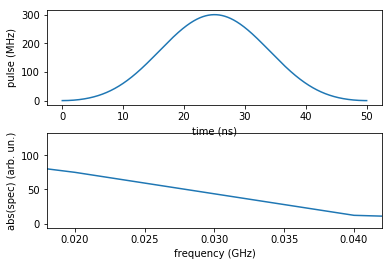

In [6]:
pulse.show()

The full numerical model will be constructed with some helper routines defined in the [model](model.py) module

In [7]:
from model import transmon_model

We decide where we want to cut off the Hilbert space for the transmon qubits, respectively the shared transmission line resonator ("cavity")

In [8]:
n_qubit = 5
n_cavity = 6

In [9]:
model = transmon_model(
    n_qubit, n_cavity, w1, w2, wc, wd, alpha1, alpha2, g, gamma, kappa,
    lambda_a=1.0, pulse=pulse, dissipation_model='non-Hermitian')

The combination of zero decay and `dissipation_model='non-Hermitian'` leads to a propagation of the the standard Schrödinger equation in Hilbert space.

In [10]:
model.write_to_runfolder("./rf")

If we're using the RWA (`wd != 0`), we also have to write the RWA vector to the runfolder

In [11]:
import numpy as np
np.savetxt('./rf/rwa_vector.dat',
           model.rwa_vector, header='rwa vector [MHz]')

This completes the generation of the input data. We can now use the `qdyn_prop_gate` utility to propagate all the two-qubit transmon states:

In [12]:
! qdyn_prop_gate ./rf

*** Read config file ./rf/config ***
*** Done reading config file ***
*** Initializing system ***
  *** Initializing grid ***
  No explicit grid found in config file! Initializing grid as one dimensional 1x1 fake grid
    Initializing grid as 1D cartesian grid without mapping
      Number of grid points was set to nr = 1 for dimension dim = 1! Initializing dimension 1 as a 1x1 fake-grid...
  *** Initializing pulses ***
    1 pulses in config file
    Initializing pulse 1
  *** Initializing dynamical generator ***
*** Done with initialization ***



This results in a file `U_over_t.dat` in the runfolder.

You could also propagate just a single state, using `qdyn_prop_traj`.
Note, however, that currently are no observables defined in model. The propagation would therefore not generate any output. We can fix this by constructing an observable operator (as a QuTiP object, in the same way as the Hamiltonian is constructed in `model.py`), and adding it to the model.

For example, we might want the expectation value for the excitation of the cavity

In [13]:
from qnet.algebra import LocalSpace, Destroy
from qnet.convert import convert_to_qutip

In [14]:
HilQ1 = LocalSpace('1', dimension=n_qubit)
HilQ2 = LocalSpace('2', dimension=n_qubit)
HilCav = LocalSpace('c', dimension=n_cavity)
a = Destroy(hs=HilCav); a_dag = a.adjoint()
obs = convert_to_qutip(a_dag * a, full_space=HilQ1*HilQ2*HilCav)

In [15]:
obs

Quantum object: dims = [[5, 5, 6], [5, 5, 6]], shape = (150, 150), type = oper, isherm = True
Qobj data =
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  2. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  3.  0.  0.]
 [ 0.  0.  0. ...,  0.  4.  0.]
 [ 0.  0.  0. ...,  0.  0.  5.]]

In [16]:
model.add_observable(obs, 'cavity_excitation.dat', exp_unit='dimensionless', time_unit='ns', col_label='<n>')

In [17]:
model.write_to_runfolder("./rf2")
np.savetxt('./rf2/rwa_vector.dat',
           model.rwa_vector, header='rwa vector [MHz]')

This can now be propagated through

In [18]:
! qdyn_prop_traj --state-label=00 ./rf2

*** Read config file ./rf2/config ***
*** Done reading config file ***
*** Initializing system ***
  *** Initializing grid ***
  No explicit grid found in config file! Initializing grid as one dimensional 1x1 fake grid
    Initializing grid as 1D cartesian grid without mapping
      Number of grid points was set to nr = 1 for dimension dim = 1! Initializing dimension 1 as a 1x1 fake-grid...
  *** Initializing pulses ***
    1 pulses in config file
    Initializing pulse 1
  *** Initializing dynamical generator ***
*** Done with initialization ***

Completed traj 1/1 in proc 1/1
Writing avg in proc 1/1


This produces `cavity_excitation.dat` in the runfolder.